In [ ]:
from google.colab import files
from google.colab import drive
import json
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/HackEPS

[Errno 2] No such file or directory: 'drive/MyDrive/HackEPS'
/content/drive/MyDrive/HackEPS


In [ ]:
%ls

JSON-CA_Prices.json  restb_rforest.joblib  restb_xgboost.joblib


In [ ]:
with open('JSON-CA_Prices.json', 'r') as f:
    loaded_json = json.loads(f.read())

In [ ]:
comparables = loaded_json["response"]["comparables"]
data_list = []

#Take the values that we want from the JSON
for comp in comparables:
    row = {
        "bathroom_r1r6": comp["image_data"]["r1r6"]["bathroom"],
        "exterior_r1r6": comp["image_data"]["r1r6"]["exterior"],
        "interior_r1r6": comp["image_data"]["r1r6"]["interior"],
        "kitchen_r1r6": comp["image_data"]["r1r6"]["kitchen"],
        "property_r1r6": comp["image_data"]["r1r6"]["property"],
        "property_type": comp["property"]["property_type"],
        "bathrooms_full": comp["structure"]["bathrooms_full"],
        "bedrooms_total": comp["structure"]["bedrooms_total"],
        "living_area": comp["structure"]["living_area"],
        "postal_code": comp["location"]["address"]["postal_code"],
        "close_price": comp["listing"]["close_price"],
    }
    data_list.append(row)

# Create DF
df = pd.DataFrame(data_list)

In [ ]:
print(df.head(10))

   bathroom_r1r6  exterior_r1r6  interior_r1r6  kitchen_r1r6  property_r1r6  \
0            3.0            3.5            2.9           3.2            3.1   
1            3.5            2.6            3.2           3.1            3.1   
2            3.4            3.3            2.9           3.0            3.1   
3            3.2            NaN            3.0           2.9            3.0   
4            3.6            2.1            2.9           3.0            3.0   
5            3.6            3.1            3.0           3.0            3.2   
6            3.5            3.0            2.7           3.5            3.2   
7            NaN            3.2            NaN           NaN            3.2   
8            3.2            3.0            2.5           3.3            3.0   
9            3.6            2.7            2.9           3.9            3.3   

                    property_type  bathrooms_full  bedrooms_total  \
0                        townhome             2.0            

In [ ]:
print(df.info())
print("---------------")
for column_name in df.columns:
    print(column_name)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathroom_r1r6   490 non-null    float64
 1   exterior_r1r6   557 non-null    float64
 2   interior_r1r6   524 non-null    float64
 3   kitchen_r1r6    516 non-null    float64
 4   property_r1r6   600 non-null    float64
 5   property_type   611 non-null    object 
 6   bathrooms_full  609 non-null    float64
 7   bedrooms_total  609 non-null    float64
 8   living_area     611 non-null    float64
 9   postal_code     611 non-null    object 
 10  close_price     611 non-null    float64
dtypes: float64(9), object(2)
memory usage: 52.6+ KB
None
---------------
bathroom_r1r6
exterior_r1r6
interior_r1r6
kitchen_r1r6
property_r1r6
property_type
bathrooms_full
bedrooms_total
living_area
postal_code
close_price


In [ ]:
df = df.dropna()

df.head()

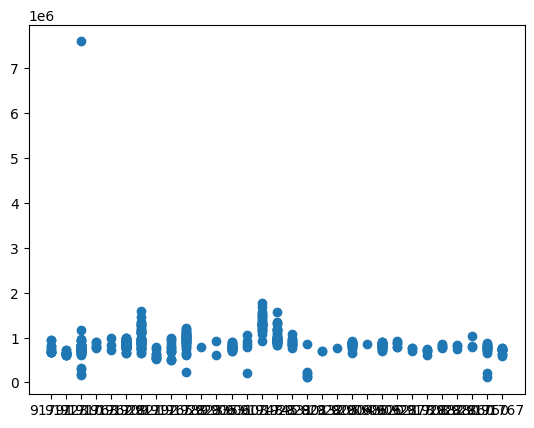

In [ ]:
plt.scatter(df['postal_code'], df['close_price'])

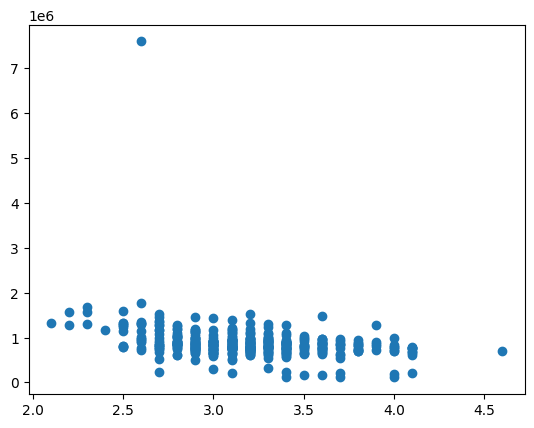

In [ ]:
plt.scatter(df['property_r1r6'], df['close_price'])

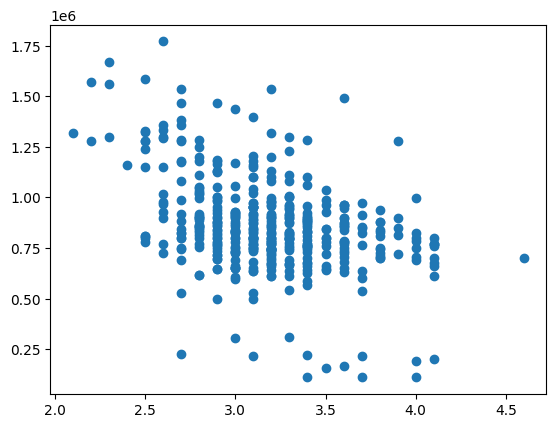

In [ ]:
df = df[df['close_price'] <= 2000000]
plt.scatter(df['property_r1r6'], df['close_price'])

In [ ]:
model_df = df.copy()

In [ ]:
print(model_df['property_type'])

0                            townhome
1                            townhome
2                            townhome
4      general single family attached
5      general single family attached
                    ...              
601    general single family detached
603    general single family detached
604    general single family detached
605    general single family detached
609    general single family detached
Name: property_type, Length: 434, dtype: category
Categories (5, object): ['general manufactured', 'general single family',
                         'general single family attached', 'general single family detached', 'townhome']


In [ ]:
model_df_encoded = pd.get_dummies(model_df, columns=['property_type', 'postal_code'])

In [ ]:
model_df.columns

Index(['bathroom_r1r6', 'exterior_r1r6', 'interior_r1r6', 'kitchen_r1r6',
       'property_r1r6', 'property_type', 'bathrooms_full', 'bedrooms_total',
       'living_area', 'postal_code', 'close_price'],
      dtype='object')

In [ ]:
model_df.head(10)

,bathroom_r1r6,exterior_r1r6,interior_r1r6,kitchen_r1r6,property_r1r6,property_type,bathrooms_full,bedrooms_total,living_area,postal_code,close_price
0,3.0,3.5,2.9,3.2,3.1,townhome,2.0,6.0,1891.0,91791,950000.0
1,3.5,2.6,3.2,3.1,3.1,townhome,3.0,3.0,1570.0,91723,635000.0
2,3.4,3.3,2.9,3.0,3.1,townhome,3.0,4.0,1923.0,91791,752000.0
4,3.6,2.1,2.9,3.0,3.0,general single family attached,3.0,3.0,1560.0,91723,651000.0
5,3.6,3.1,3.0,3.0,3.2,general single family attached,2.0,3.0,1833.0,91723,610000.0
6,3.5,3.0,2.7,3.5,3.2,general single family attached,2.0,3.0,1615.0,91791,670000.0
8,3.2,3.0,2.5,3.3,3.0,general single family attached,2.0,3.0,1826.0,91723,650000.0
9,3.6,2.7,2.9,3.9,3.3,general single family attached,2.0,3.0,1940.0,91791,670000.0
13,3.5,2.1,2.9,3.0,2.9,general single family attached,3.0,3.0,1570.0,91723,645000.0
15,3.0,2.5,2.8,3.1,2.9,general single family attached,3.0,4.0,2050.0,91723,716900.0


In [ ]:
model_df_encoded.head(10)

,bathroom_r1r6,exterior_r1r6,interior_r1r6,kitchen_r1r6,property_r1r6,bathrooms_full,bedrooms_total,living_area,close_price,property_type_general manufactured,...,postal_code_92805,postal_code_92821,postal_code_92823,postal_code_92831,postal_code_92832,postal_code_92835,postal_code_92860,postal_code_92878,postal_code_92880,postal_code_92882
0,3.0,3.5,2.9,3.2,3.1,2.0,6.0,1891.0,950000.0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.5,2.6,3.2,3.1,3.1,3.0,3.0,1570.0,635000.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.4,3.3,2.9,3.0,3.1,3.0,4.0,1923.0,752000.0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.6,2.1,2.9,3.0,3.0,3.0,3.0,1560.0,651000.0,0,...,0,0,0,0,0,0,0,0,0,0
5,3.6,3.1,3.0,3.0,3.2,2.0,3.0,1833.0,610000.0,0,...,0,0,0,0,0,0,0,0,0,0
6,3.5,3.0,2.7,3.5,3.2,2.0,3.0,1615.0,670000.0,0,...,0,0,0,0,0,0,0,0,0,0
8,3.2,3.0,2.5,3.3,3.0,2.0,3.0,1826.0,650000.0,0,...,0,0,0,0,0,0,0,0,0,0
9,3.6,2.7,2.9,3.9,3.3,2.0,3.0,1940.0,670000.0,0,...,0,0,0,0,0,0,0,0,0,0
13,3.5,2.1,2.9,3.0,2.9,3.0,3.0,1570.0,645000.0,0,...,0,0,0,0,0,0,0,0,0,0
15,3.0,2.5,2.8,3.1,2.9,3.0,4.0,2050.0,716900.0,0,...,0,0,0,0,0,0,0,0,0,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['bathroom_r1r6'].plot(kind='hist', bins=20, title='bathroom_r1r6')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['exterior_r1r6'].plot(kind='hist', bins=20, title='exterior_r1r6')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['interior_r1r6'].plot(kind='hist', bins=20, title='interior_r1r6')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='bathroom_r1r6', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='bathroom_r1r6', y='exterior_r1r6', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='exterior_r1r6', y='interior_r1r6', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='interior_r1r6', y='kitchen_r1r6', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['bathroom_r1r6']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('bathroom_r1r6')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['exterior_r1r6']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('exterior_r1r6')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['interior_r1r6']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('interior_r1r6')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['kitchen_r1r6']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('kitchen_r1r6')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['bathroom_r1r6'].plot(kind='line', figsize=(8, 4), title='bathroom_r1r6')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['exterior_r1r6'].plot(kind='line', figsize=(8, 4), title='exterior_r1r6')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['interior_r1r6'].plot(kind='line', figsize=(8, 4), title='interior_r1r6')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
print(model_df_encoded.columns)

Index(['bathroom_r1r6', 'exterior_r1r6', 'interior_r1r6', 'kitchen_r1r6',
       'property_r1r6', 'bathrooms_full', 'bedrooms_total', 'living_area',
       'close_price', 'property_type_general manufactured',
       'property_type_general single family',
       'property_type_general single family attached',
       'property_type_general single family detached',
       'property_type_townhome', 'postal_code_90603', 'postal_code_90620',
       'postal_code_90621', 'postal_code_90631', 'postal_code_90680',
       'postal_code_91708', 'postal_code_91709', 'postal_code_91710',
       'postal_code_91723', 'postal_code_91745', 'postal_code_91748',
       'postal_code_91750', 'postal_code_91762', 'postal_code_91763',
       'postal_code_91765', 'postal_code_91767', 'postal_code_91789',
       'postal_code_91791', 'postal_code_91792', 'postal_code_92801',
       'postal_code_92804', 'postal_code_92805', 'postal_code_92821',
       'postal_code_92823', 'postal_code_92831', 'postal_code_92832',


In [ ]:
X = model_df_encoded.drop('close_price', axis=1)
y = model_df_encoded['close_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_params = {
   "n_estimators" : [10, 50, 100, 500,],
   "max_depth" : [10, 50, 100, 200],
   "random_state" : [1, 5, 33, 42]
}

#rf_model = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params, scoring='r2', verbose=3)
rf_model = RandomForestRegressor(n_estimators=10, max_depth=50, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_estimators=10, random_state=42)

In [ ]:
#print(rf_model.best_estimator_)
#print("Best Params:", rf_model.best_params_)

In [ ]:
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Imprimir las métricas
print("R²:", r2)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

R²: 0.8368306020495582
MAE: 68376.02643678161
MSE: 7553503459.540345
RMSE: 86910.89379094169


In [ ]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df.head(10))

        Actual  Predicted
413  1535000.0  1354300.0
135   755000.0   893250.0
190   896000.0   853000.0
382   880000.0   781500.0
478   837500.0   757000.0
481   885000.0   820800.0
429  1160000.0  1230715.5
142   595000.0   578600.0
523   760000.0   772500.0
568   815000.0   939000.0


In [ ]:
# Agregar una columna al DataFrame con los residuos
comparison_df['Residuals'] = comparison_df['Actual'] - comparison_df['Predicted']

# Ordenar el DataFrame por los residuos en orden descendente (mayores desviaciones primero)
sorted_comparison_df_top = comparison_df.sort_values(by='Residuals', ascending=False)

sorted_comparison_df_down = comparison_df.sort_values(by='Residuals', ascending=True)

# Mostrar las primeras 10 filas del DataFrame ordenado
print(sorted_comparison_df_top.head(10))
print("-----------------")
print(sorted_comparison_df_down.head(10))

        Actual  Predicted  Residuals
413  1535000.0  1354300.0   180700.0
390  1000000.0   842800.0   157200.0
209   925888.0   769800.0   156088.0
159   985000.0   837750.0   147250.0
125   970000.0   833040.0   136960.0
594   813000.0   700500.0   112500.0
244   310750.0   201000.0   109750.0
441   955000.0   853500.0   101500.0
316  1080000.0   981200.0    98800.0
382   880000.0   781500.0    98500.0
-----------------
        Actual  Predicted  Residuals
414  1280000.0  1486900.0  -206900.0
554   608000.0   792200.0  -184200.0
47    616000.0   780300.0  -164300.0
136   689000.0   852000.0  -163000.0
422  1240000.0  1400030.0  -160030.0
96    765000.0   924500.0  -159500.0
463   770000.0   924000.0  -154000.0
74    950000.0  1090700.0  -140700.0
135   755000.0   893250.0  -138250.0
64    690000.0   825700.0  -135700.0


In [ ]:
from datetime import datetime
joblib.dump(rf_model, "./restb_rforest_nocat.joblib")
print("Saved at: "+ str(datetime.now()))

Saved at: 2023-11-26 01:30:22.887953


In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

# Evaluar el rendimiento del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 62903.11637931035
MSE: 7232809169.16665
R²: 0.8437581813598355


In [ ]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df.head(10))

        Actual     Predicted
413  1535000.0  1.567419e+06
135   755000.0  8.414418e+05
190   896000.0  8.131641e+05
382   880000.0  7.861366e+05
478   837500.0  7.832092e+05
481   885000.0  8.245719e+05
429  1160000.0  1.171234e+06
142   595000.0  5.310346e+05
523   760000.0  8.249011e+05
568   815000.0  1.001602e+06


In [ ]:
joblib.dump(xgb_model, 'restb_xgboost_nocat.joblib')
print("Saved at: "+ str(datetime.now()))

Saved at: 2023-11-26 01:30:26.968369
